<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Необходимо построить модель для прогнозирования количества заказов такси на следующий час. 
Работы выполним в 4 этапа
1. Загрузка и подготовка данных
2. Анализ данных
3. Обучение моделей
4. Проверка данных на тестовой выборке

Задача: обучение и выбор лучшей модели
Цель: RMSE на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from math import sqrt

#!pip install catboost
from catboost import CatBoost, CatBoostRegressor, Pool

import warnings

warnings.filterwarnings("ignore")

In [2]:
RND_ST = 3101
LIMIT_RMSE = 48

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
    
except:
    data = pd.read_csv('taxi.csv')

In [4]:
data.sample(5)

,datetime,num_orders
21091,2018-07-25 11:10:00,9
9316,2018-05-04 16:40:00,11
3976,2018-03-28 14:40:00,8
6986,2018-04-18 12:20:00,8
3397,2018-03-24 14:10:00,8


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
#поменяем тип данных в колонке Datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [7]:
data = data.set_index('datetime')

In [8]:
print(data.index.is_monotonic)

True


In [9]:
print('кол-во дублей:', data.duplicated().sum())

кол-во дублей: 26415


In [10]:
data.isna()

,num_orders
datetime,
2018-03-01 00:00:00,False
2018-03-01 00:10:00,False
2018-03-01 00:20:00,False
2018-03-01 00:30:00,False
2018-03-01 00:40:00,False
...,...
2018-08-31 23:10:00,False
2018-08-31 23:20:00,False
2018-08-31 23:30:00,False


### Вывод
В датафрейме две колонки c временем и кол-вом заказов
1. Поменяли тип данных для колонки datetime и сделали ее индексом нашей таблицы
2. данные расположены в хронологическом порядке.
3. Названия колонок написаны с маленькой буквы с нижним подчеркиванием изменения не требуются.
4. Пропуски отсутствуют.
5. дубликаты отсутствуют.


## Анализ

In [11]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<AxesSubplot:xlabel='datetime'>

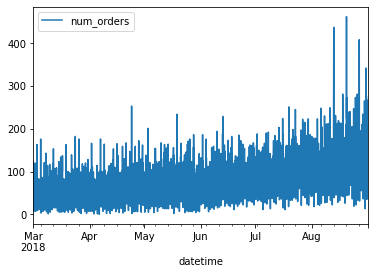

In [12]:
data = data.resample('1H').sum()
data.plot()

<AxesSubplot:xlabel='datetime'>

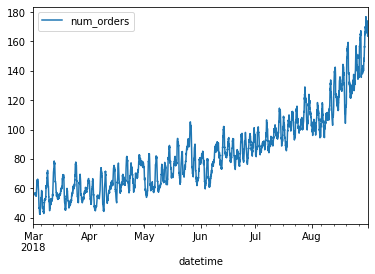

In [13]:
data.rolling(24).mean().plot()


Text(0.5, 1.0, 'Сезонность в пределах августа месяца')

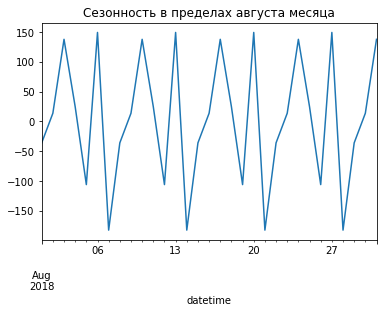

In [14]:

decomposed_d = seasonal_decompose(data.resample('1D').sum())

plt.subplot()
decomposed_d.seasonal['2018-08':'2018-08'].plot(ax=plt.gca())
plt.title('Сезонность в пределах августа месяца')

Text(0.5, 1.0, 'Сезонность в пределах марта месяца')

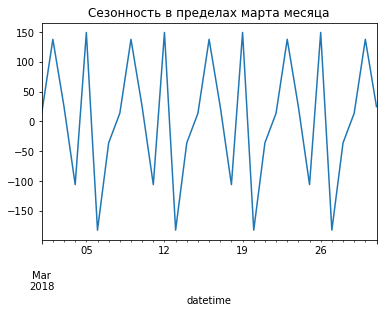

In [15]:
plt.subplot()
decomposed_d.seasonal['2018-03':'2018-03'].plot(ax=plt.gca())
plt.title('Сезонность в пределах марта месяца')

Пики использования такси приходятся на пятницу и понедельник минимум заказов на вторник.

Text(0.5, 1.0, 'trend')

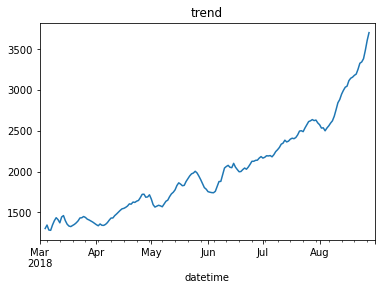

In [16]:
plt.subplot()
decomposed_d.trend.plot(ax=plt.gca())
plt.title('trend')


с марта по август кол-во заказов кратно увеличилось. В августе наблюдается резкий подъем.

In [17]:
data.index[-1]

Timestamp('2018-08-31 23:00:00', freq='H')

Text(0.5, 1.0, 'Сезонность в течение дня')

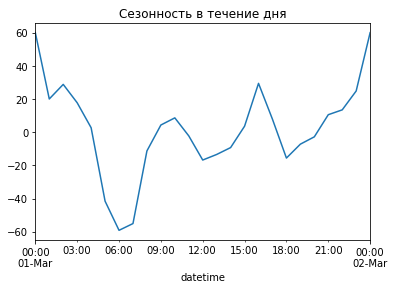

In [18]:
decomposed = seasonal_decompose(data)

plt.subplot()
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot(ax=plt.gca())

plt.title('Сезонность в течение дня')

В течение дня минимальное кол-во заказов в 6 утра пики в 10:00, 16:00 и наибольшее кол-во заказов приходится на 00:00

### Вывод
Изучили данные о количестве заказов
1. с марта по август кол-во заказов кратно увеличилось. В августе наблюдается резкий подъем.
2. В разрезе ндели наблюдается сезонность Пики использования такси приходятся на пятницу и понедельник минимум заказов на вторник.
3. В течение дня минимальное кол-во заказов в 6 утра пики в 10:00, 16:00 и наибольшее кол-во заказов приходится на 00:00

## Обучение

In [19]:
# Напишем функцию для добавления данных (год, месяц, день, день недели, 
                                         # отстающие значения и скользящее среднее) в нашу таблицу 
    
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [20]:
# Заполним данные отстающими значениями за неделю для сохранения данных о сезонности.
make_features(data, 168, 3)

In [21]:
# Разделим выборку на тренировочную и тестовую

train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()

print('Границы тренировочной выборки:', train.index.min(),'-', train.index.max())

print('Границы тестовой выборки:', test.index.min(),'-', test.index.max())

Границы тренировочной выборки: 2018-03-03 00:00:00 - 2018-08-13 13:00:00
Границы тестовой выборки: 2018-08-13 14:00:00 - 2018-08-31 23:00:00


In [22]:
feature_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

feature_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [23]:
# напишем функцию для расчета RMSE
def rmse(target, prediction):
    return mean_squared_error(target, prediction)**0.5

RMSE_scorer = make_scorer(rmse, greater_is_better=False)

In [24]:
#подготовим переменные для сбора данных

model_name = []
model_rmse = []

In [25]:
# оценим модель с помощью кроссвалидации features_train_rougher, target_train_rougher. Вычислим sMAPE_rougher
model_line_reg = LinearRegression()

line_reg = cross_val_score(model_line_reg,
                           feature_train,
                           target_train,
                           scoring = RMSE_scorer,
                           cv = 5)

line_reg_RMSE = np.mean(abs(line_reg))

print('RMSE для LinearRegression:', line_reg_RMSE)


RMSE для LinearRegression: 23.507120021970614


In [26]:
model_name.append('LinearRegression')
model_rmse.append(line_reg_RMSE)

In [27]:
DTreg = DecisionTreeRegressor()

param_grid = {"max_depth": range(2, 20, 4)}

rs_DTreg = RandomizedSearchCV(estimator = DTreg,
                              param_distributions =param_grid,
                              cv=3, random_state=RND_ST,
                              scoring = RMSE_scorer,
                              verbose = 2, n_jobs = -1) 


rs_DTreg.fit(feature_train, target_train)


y_pred_rs = rs_DTreg.predict(feature_train)

rmse_rs_DTreg = abs(rs_DTreg.best_score_)

rs_DTreg_param = rs_DTreg.best_params_

print('RMSE для DecisionTreeRegressor:', rmse_rs_DTreg)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
RMSE для DecisionTreeRegressor: 29.323477484384142


In [28]:
model_name.append('DecisionTreeRegressor')
model_rmse.append(rmse_rs_DTreg)

In [29]:
cat = CatBoostRegressor(custom_metric= ['RMSE'],
                        learning_rate=0.03,
                        n_estimators=1500,
                        random_seed=RND_ST)


cat.fit(feature_train, target_train,verbose=100, plot=True)

rmse_cat = cat.best_score_['learn']['RMSE']

print('RMSE для CatBoostRegressor estimators 1500:', rmse_cat)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 38.0888048	total: 149ms	remaining: 3m 43s
100:	learn: 22.7136545	total: 1.4s	remaining: 19.4s
200:	learn: 20.9386901	total: 2.67s	remaining: 17.2s
300:	learn: 19.8356605	total: 3.89s	remaining: 15.5s
400:	learn: 18.5088302	total: 5.2s	remaining: 14.3s
500:	learn: 17.4046756	total: 6.51s	remaining: 13s
600:	learn: 16.4509363	total: 8.14s	remaining: 12.2s
700:	learn: 15.6309081	total: 9.88s	remaining: 11.3s
800:	learn: 14.8268302	total: 11.1s	remaining: 9.69s
900:	learn: 14.1163480	total: 12.3s	remaining: 8.18s
1000:	learn: 13.4723555	total: 13.6s	remaining: 6.75s
1100:	learn: 12.8485111	total: 14.8s	remaining: 5.35s
1200:	learn: 12.2859172	total: 16s	remaining: 3.99s
1300:	learn: 11.7533610	total: 17.3s	remaining: 2.64s
1400:	learn: 11.3005019	total: 18.4s	remaining: 1.3s
1499:	learn: 10.8271471	total: 19.4s	remaining: 0us
RMSE для CatBoostRegressor estimators 500: 10.827147104727942


In [30]:
model_name.append('CatBoostRegressor')
model_rmse.append(rmse_cat)

In [31]:
# Соберем в датафрейм полученные результаты со всех моделей.

scores = pd.DataFrame( {'Name' : model_name, 
                       'RMSE' : model_rmse}) 

scores.sort_values('RMSE', ascending=True).reset_index(drop=True)

,Name,RMSE
0,CatBoostRegressor,10.827147
1,LinearRegression,23.507120
2,DecisionTreeRegressor,29.323477


### Вывод
Подготовили и обучили три модели LinearRegression, DecisionTreeRegressor, CatBoostRegressor

На тренировочных данных все модели прошли рубеж RMSE < 48 лучший результат показала модель CatBoostRegressor Со значением RMSE = 10.8
На ней произведем финальное тестирование

## Тестирование

In [32]:
pred = cat.predict(feature_test)
print("RMSE:", mean_squared_error(target_test,pred, squared=False))

RMSE: 38.09509159941506


In [36]:
#Проверим модель на адекватность предыдущими значениями
pred_previous = test.shift()
pred_previous.iloc[0]=train.iloc[-1]
print("RMSE:", rmse(test['num_orders'],pred_previous['num_orders']))

RMSE: 58.856486242815066


### Вывод

В исходном датафрейме две колонки c временем и кол-вом заказов за период 2018-03-01 - 2018-08-31
1. Поменяли тип данных для колонки datetime и сделали ее индексом нашей таблицы
2. данные расположены в хронологическом порядке.
3. Названия колонок написаны с маленькой буквы с нижним подчеркиванием изменения не требуются.
4. Пропуски отсутствуют.
5. дубликаты отсутствуют.

Изучили данные о количестве заказов
1. с марта по август кол-во заказов кратно увеличилось. В августе наблюдается резкий подъем.
2. В разрезе недели наблюдается сезонность Пики использования такси приходятся на пятницу и понедельник минимум заказов на вторник.
3. В течение дня минимальное кол-во заказов в 6 утра пики в 10:00, 16:00 и наибольшее кол-во заказов приходится на 00:00

Подготовили и обучили три модели LinearRegression, DecisionTreeRegressor, CatBoostRegressor

На тренировочных данных все модели прошли рубеж RMSE < 48 лучший результат показала модель CatBoostRegressor Со значением RMSE = 10.8
На ней произвели финальное тестирование RMSE = 38, Не смотря на то что модель переобучилась результат с запасом ниже 48.

Цели и задачи проекта выполнены.